# Milestone Project 2 SkimLit

- The purpose is to build an NLP model to read medical asbstracts. 
- Paper being replicated is: https://arxiv.org/abs/1710.06071
- Model being replicated that the above paper used: https://arxiv.org/abs/1612.05251


Adapted from Course - ZTM Tensorflow Developer Certificate Course 2022.

## Get Data

Data is available at: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
# dev.txt is the validation set

dev.txt   test.txt  train.txt


In [5]:
# Start the experiments with 20k RCT numbers replaced with `@` sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all the file names in data
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data

In [7]:
# Create a function to read files of a document

def get_lines(filename):
    """
    Reads filename and returns the lines of text as a list
    """
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
# Training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [9]:
# Need to separate labels from text -> Dict

def preprocess_text_with_line_numbers(filename):
    """
    Return a list of dicts of abstract line data
    """
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    # loop through each line in target file
    for line in input_lines:

        if line.startswith("###"):
            
            abstract_id = line
            abstract_lines = ""
        
        elif line.isspace():

            abstract_lines_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_lines_split):

                line_data = {}

                target_text_split = abstract_line.split("\t")

                line_data["target"] = target_text_split[0]

                line_data["text"] = target_text_split[1].lower()

                line_data["line_number"] = abstract_line_number

                line_data["total_lines"] = len(abstract_lines_split) -1

                abstract_samples.append(line_data)
        else: # line contains a labeled sentence

            abstract_lines += line

    return abstract_samples


In [10]:
# Get data and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
# To better Viz the data -> List of Dict => DataFrame
import pandas as pd
train_df = pd.DataFrame(train_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [12]:
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
# Check distribution of training data
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

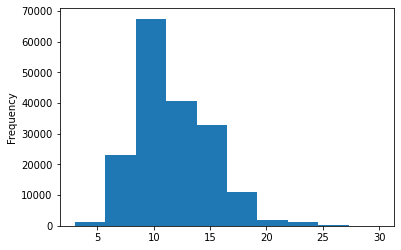

In [14]:
# Let's check the length of the different lines
train_df["total_lines"].plot.hist()

In [15]:
# Convert abstract text lines to list
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [16]:
# Convert target labels to numeric

# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse=False) # non spare matrix
train_labels_one_hot = one_hot.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
val_labels_one_hot = one_hot.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot.transform(test_df["target"].to_numpy().reshape(-1, 1))


In [18]:
# Label Encode Labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## About the sentences

In [19]:
# How long is each sentence on average
import numpy as np
sent_length = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_length)
avg_sent_len


26.338269273494777

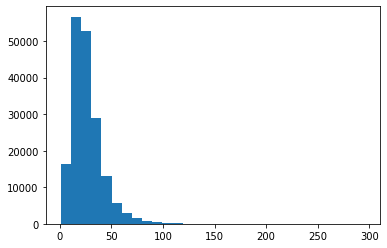

In [20]:
# What's the distribution
import matplotlib.pyplot as plt
plt.hist(sent_length, bins = 30);

In [21]:
# How long of a sentence length covers 95% of the training sentences
OUTPUT_SEQ_LENGHT = int(np.percentile(sent_length, 95))
OUTPUT_SEQ_LENGHT

55

## Get helper functions

In [22]:
from helper_functions import calculate_results

## Model Experiments:
1. `Model 0`: Baseline
2. `Model 1`: Conv1D With Token Embeddings
3. `Model 2`: Tensorflow Hub Feature Extractor
4. `Model 3`: Model 2 + Character Embeddings
5. `Model 4`: Model 3 + Positional Embeddings

### Model 0: Baseline

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
            y = val_labels_encoded)

0.7218323844829869

In [25]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_0.predict(val_sentences))
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Text Vectorizer Layer

In [26]:
# How many words are in the vocab -> Table2 https://arxiv.org/abs/1710.06071

MAX_TOKENS = 68_000

In [27]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(
                                    max_tokens = MAX_TOKENS,
                                    output_sequence_length = OUTPUT_SEQ_LENGHT
                                    )

2022-06-06 23:02:16.211329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [29]:
# Words in training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

In [30]:
# Token Embeddings Layer
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                                output_dim = 128,
                                mask_zero = True,
                                name = "token_embedding")

### Creating Datasets Using Tensorflow Data API for Faster Performance and Data Loading

In [31]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [32]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [33]:
# Prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Model 1: Conv1D with Token Embeddings

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [35]:
# create 1d conv model
inputs = layers.Input(shape = (1, ), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same",
                 activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name = "conv1d_model")


In [36]:
# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
model_1.summary()               

Model: "conv1d_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                

In [37]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                             steps_per_epoch = int(0.1*len(train_dataset)),
                             epochs = 5,
                             validation_data = val_dataset,
                             validation_steps = int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 46s 81ms/step - loss: 0.9195 - accuracy: 0.6362 - val_loss: 0.6908 - val_accuracy: 0.7364
Epoch 2/5
562/562 [==============================] - 45s 80ms/step - loss: 0.6617 - accuracy: 0.7539 - val_loss: 0.6321 - val_accuracy: 0.7683
Epoch 3/5
562/562 [==============================] - 45s 81ms/step - loss: 0.6208 - accuracy: 0.7740 - val_loss: 0.6001 - val_accuracy: 0.7856
Epoch 4/5
562/562 [==============================] - 52s 93ms/step - loss: 0.5911 - accuracy: 0.7903 - val_loss: 0.5824 - val_accuracy: 0.7896
Epoch 5/5
562/562 [==============================] - 43s 77ms/step - loss: 0.5911 - accuracy: 0.7909 - val_loss: 0.5617 - val_accuracy: 0.7992


In [38]:
# Evaluate model on validation
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5608 - accuracy: 0.8019


[0.5608431100845337, 0.8019329905509949]

In [39]:
# Calcualte results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = tf.argmax(model_1.predict(val_dataset), axis = 1))
model_1_results

945/945 [==============================] - 4s 4ms/step


{'accuracy': 80.19330067522839,
 'precision': 0.801338653829368,
 'recall': 0.8019330067522839,
 'f1': 0.7989160881248668}

In [40]:
# Convert the prediction probabilities to class to compare with actual labels
model_1_preds = tf.argmax(model_1.predict(val_dataset), axis = 1)
model_1_preds

945/945 [==============================] - 4s 4ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

### Model 2: Transfer Learning Tensorflow Hub Universal Sentence Encoder

In [41]:
# Download pretrained USE model
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                    trainable = False, name = "USE")


In [42]:
# Build the model
inputs = layers.Input(shape = [], dtype = tf.string)
embeddings = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = "relu")(embeddings)
outputs = layers.Dense(5, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "USE_Model")

# Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_model_2 = model_2.fit(train_dataset,
                             steps_per_epoch = int(0.1*len(train_dataset)),
                             epochs = 5,
                             validation_data = val_dataset,
                             validation_steps = int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 11s 15ms/step - loss: 0.9161 - accuracy: 0.6506 - val_loss: 0.7967 - val_accuracy: 0.6922
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7690 - accuracy: 0.7003 - val_loss: 0.7551 - val_accuracy: 0.7018
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7532 - accuracy: 0.7119 - val_loss: 0.7386 - val_accuracy: 0.7134
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7196 - accuracy: 0.7233 - val_loss: 0.7101 - val_accuracy: 0.7297
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7272 - accuracy: 0.7211 - val_loss: 0.6902 - val_accuracy: 0.7344


In [43]:
# Evaluate the model
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred=tf.argmax(model_2.predict(val_dataset), axis =1))
model_2_results

945/945 [==============================] - 9s 10ms/step


{'accuracy': 73.29206937640672,
 'precision': 0.7290210789158778,
 'recall': 0.7329206937640672,
 'f1': 0.7272477142976872}

### Model 3: Character Level + Model 1

In [45]:
# Make a function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))


# Text Splitting non-character-level sequences into characters
train_chars = [split_chars(sentences) for sentences in train_sentences]
val_chars = [split_chars(sentences) for sentences in val_sentences]
test_chars = [split_chars(sentences) for sentences in test_sentences]

In [46]:
# What is the average character lenght
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

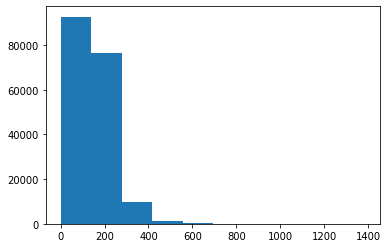

In [49]:
# Check distribution for sequence at character-level
plt.hist(char_len, bins = 10); 

In [51]:
# What character level cover 95% of sequences
OUTPUT_SEQ_LENGHT_CHAR = int(np.percentile(char_len, 95))
OUTPUT_SEQ_LENGHT_CHAR

290

In [53]:
# Create-char level token vectorizer instance
import string
NUM_CHAR_TOKENS = len(string.ascii_lowercase +
                      string.digits +
                      string.punctuation) + 2
char_vectorizer = TextVectorization(
        max_tokens = NUM_CHAR_TOKENS,
        output_sequence_length = OUTPUT_SEQ_LENGHT_CHAR
        ,name = "char_vectorizer")

In [54]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [57]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(len(char_vocab))
print(char_vocab[:5])
print(char_vocab[:-5])

28
['', '[UNK]', 'e', 't', 'i']
['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's', 'd', 'c', 'l', 'h', 'p', 'm', 'u', 'f', 'g', 'y', 'w', 'v', 'b']


In [58]:
# Create the embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab),
                             output_dim = 25, mask_zero = True,
                            name = "char_embed")

In [63]:
# Build the model
inputs = layers.Input(shape = (1, ), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same",
                    activation = "relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_cov1d_char_embeds")

# Compile the model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Build the dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


# Fit the model

history_model_3 = model_3.fit(train_char_dataset,
                             steps_per_epoch = int(0.1*len(train_char_dataset)),
                             epochs= 5,
                             validation_data = val_char_dataset,
                             validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 8s 13ms/step - loss: 1.4565 - accuracy: 0.3496 - val_loss: 1.3929 - val_accuracy: 0.4079
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 1.3467 - accuracy: 0.4313 - val_loss: 1.3160 - val_accuracy: 0.4521
Epoch 3/5
562/562 [==============================] - 8s 15ms/step - loss: 1.3128 - accuracy: 0.4554 - val_loss: 1.3061 - val_accuracy: 0.4441
Epoch 4/5
562/562 [==============================] - 10s 17ms/step - loss: 1.2920 - accuracy: 0.4612 - val_loss: 1.2877 - val_accuracy: 0.4644
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 1.2874 - accuracy: 0.4585 - val_loss: 1.2768 - val_accuracy: 0.4724


In [65]:
# Evaluate the model
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = tf.argmax(model_3.predict(val_char_dataset), axis = 1))
model_3_results

945/945 [==============================] - 6s 6ms/step


{'accuracy': 47.32887594333378,
 'precision': 0.4272956986176429,
 'recall': 0.47328875943333776,
 'f1': 0.42828049457863965}

### Model 4: Combining Pretrained Token Embedding + Character Embeddings

1. Create a token-level embedding (model 1)
2. Create a character level embedding (model 3)
3. Combine and 1 and 2 with a concatenate layer

In [66]:
# 1. Setup Token inputs/models

token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

# 2. Setup char input/model

char_inputs = layers.Input(shape = (1, ), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

# 3. Concatenate token and char inputs

token_char_concat = layers.Concatenate(name = "token_char_hybrid")([
    token_model.output, char_model.output
])

# 4. Build a series of output layers and dropout layer

combined_output = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_output)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation = "softmax")(final_dropout)

model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                        outputs = output_layer,
                        name = "model_4_token_and_char_embeddings")

In [73]:
# Plot hybrid model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [74]:
# Compile the model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

#### Combine Char and Token data in tf.data Dataset

In [75]:
# Combine tokens and chars
train_token_char_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(
    train_labels_one_hot
)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data,
train_token_char_labels))
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
# Combine tokens and chars - validation
val_token_char_data = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(
    val_labels_one_hot
)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data,
val_token_char_labels))
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
# Fit the model
history_model_4 = model_4.fit(train_token_char_dataset,
                            steps_per_epoch = int(0.1*len(train_token_char_dataset)),
                            epochs = 5,
                            validation_data = val_token_char_dataset,
                            validation_steps = int(0.1*len(val_token_char_dataset)))

Epoch 1/5
562/562 [==============================] - 112s 180ms/step - loss: 0.9874 - accuracy: 0.6033 - val_loss: 0.7824 - val_accuracy: 0.7045
Epoch 2/5
562/562 [==============================] - 85s 152ms/step - loss: 0.8103 - accuracy: 0.6874 - val_loss: 0.7204 - val_accuracy: 0.7244
Epoch 3/5
562/562 [==============================] - 84s 150ms/step - loss: 0.7845 - accuracy: 0.7002 - val_loss: 0.7124 - val_accuracy: 0.7284
Epoch 4/5
562/562 [==============================] - 84s 150ms/step - loss: 0.7491 - accuracy: 0.7179 - val_loss: 0.6742 - val_accuracy: 0.7497
Epoch 5/5
562/562 [==============================] - 85s 150ms/step - loss: 0.7518 - accuracy: 0.7151 - val_loss: 0.6637 - val_accuracy: 0.7510


In [79]:
# Evaluate the model
print(model_4.evaluate(val_token_char_dataset))

model_4_results = calculate_results(y_true = val_labels_encoded,
                                y_pred = tf.argmax(model_4.predict(val_token_char_dataset), axis = 1))
print(model_4_results)

945/945 [==============================] - 36s 38ms/step - loss: 0.6681 - accuracy: 0.7466
[0.668080747127533, 0.7465576529502869]
945/945 [==============================] - 35s 37ms/step
{'accuracy': 74.65576592082617, 'precision': 0.7453997813731088, 'recall': 0.7465576592082617, 'f1': 0.7411538515393846}


### Model 5: Pretrained Embeddings + Character Embeddings + Positional Embeddings

#### Create Positional Embeddings

In [80]:
# How many line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

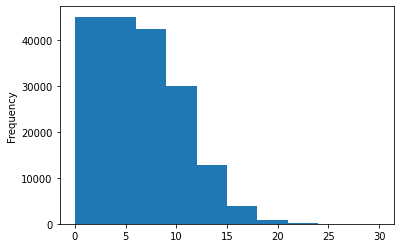

In [82]:
# Check the distribution of line number
train_df.line_number.plot.hist();

In [85]:
# Use tensorflow to create one-hot-encoded tensors for line numbers
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)
train_line_numbers_one_hot[:5], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64


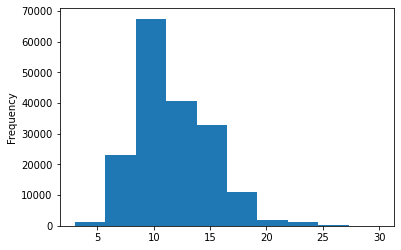

In [87]:
# Total lines
print(train_df["total_lines"].value_counts())
train_df.total_lines.plot.hist();

In [89]:
# Check the average of a total lines coverage given a 98 percentile
np.percentile(train_df.total_lines, 98)

20.0

In [92]:
# one hot total lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)

train_total_lines_one_hot[:5], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]))

In [96]:
# Token Inputs
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                            outputs = token_outputs)

# Char Inputs
char_inputs = layers.Input(shape = (1, ), dtype = tf.string, name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# Line Number Inputs
line_inputs = layers.Input(shape = (15, ), dtype = tf.float32, name = "line_inputs")
dense_layer_1 = layers.Dense(32, activation = "relu")(line_inputs)
line_model = tf.keras.Model(inputs = line_inputs,
                            outputs = dense_layer_1)


# Total Lines Input
total_lines_inputs = layers.Input(shape = (20, ), dtype = tf.float32, name = "total_line_inputs")
dense_layer_2 = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs = total_lines_inputs,
                            outputs = dense_layer_2)

# Combine the embeddings

combined_embeddings = layers.Concatenate(name = "char_token_hybrid_embeddings")(
    [token_model.output, char_model.output]
)

# Dropout
z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)


# Combined positional embeddings

tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embeddings")(
    [line_model.output, total_line_model.output,
    z]
)

# Create output layer
output_layer = layers.Dense(5, activation = "softmax", name = "output_layer")(tribrid_embeddings)

# Model
model_5 = tf.keras.Model(inputs = [
    line_model.input, total_line_model.input,
    token_model.input, char_model.input
],
outputs = output_layer, name = "tribrid_embeddings_model")


In [97]:
# Summary of Model
model_5.summary()

Model: "tribrid_embeddings_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_in

In [98]:
plot_model(model_5)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [109]:
# Compile Model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [104]:
# Create tribrid embeddings dataset using tf.data

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices(
    (train_line_numbers_one_hot, train_total_lines_one_hot,
    train_sentences, train_chars)
)
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(
    train_labels_one_hot
)
train_char_token_pos_dataset = tf.data.Dataset.zip(
    (train_char_token_pos_data, train_char_token_pos_labels)
)
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [105]:
# Create tribrid embeddings dataset using tf.data - validation

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices(
    (val_line_numbers_one_hot, val_total_lines_one_hot,
    val_sentences, val_chars)
)
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(
    val_labels_one_hot
)
val_char_token_pos_dataset = tf.data.Dataset.zip(
    (val_char_token_pos_data, val_char_token_pos_labels)
)
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [106]:
# Create tribrid embeddings dataset using tf.data - test

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices(
    (test_line_numbers_one_hot, test_total_lines_one_hot,
    test_sentences, test_chars)
)
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(
    test_labels_one_hot
)
test_char_token_pos_dataset = tf.data.Dataset.zip(
    (test_char_token_pos_data, test_char_token_pos_labels)
)
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [108]:
train_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [110]:
# Fit the model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                             steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                             epochs = 5,
                             validation_data = val_char_token_pos_dataset,
                             validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 152s 259ms/step - loss: 0.9987 - accuracy: 0.7969 - val_loss: 0.9689 - val_accuracy: 0.8128
Epoch 2/5
562/562 [==============================] - 113s 201ms/step - loss: 0.9582 - accuracy: 0.8226 - val_loss: 0.9407 - val_accuracy: 0.8371
Epoch 3/5
562/562 [==============================] - 100s 178ms/step - loss: 0.9451 - accuracy: 0.8278 - val_loss: 0.9359 - val_accuracy: 0.8368
Epoch 4/5
562/562 [==============================] - 140s 249ms/step - loss: 0.9365 - accuracy: 0.8370 - val_loss: 0.9261 - val_accuracy: 0.8364
Epoch 5/5
562/562 [==============================] - 152s 271ms/step - loss: 0.9340 - accuracy: 0.8391 - val_loss: 0.9227 - val_accuracy: 0.8428


In [111]:
# Evaluate the model
print(model_5.evaluate(val_char_token_pos_dataset))

model_5_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = tf.argmax(model_5.predict(val_char_token_pos_dataset), axis = 1)
)
model_5_results

945/945 [==============================] - 60s 64ms/step - loss: 0.9209 - accuracy: 0.8427
[0.9209386110305786, 0.8427445888519287]
945/945 [==============================] - 42s 40ms/step


{'accuracy': 84.27446047927975,
 'precision': 0.8455186635162628,
 'recall': 0.8427446047927976,
 'f1': 0.8387264740327381}

## Compare Model Results

In [116]:
# Model Results

all_model_results = pd.DataFrame(
    {
      "model_0_baseline": baseline_results,
      "model_1_custom_tokens_embed": model_1_results,
      "model_2_pretrained_tokens_embed_USE": model_2_results,
      "model_3_custom_char_embeddings": model_3_results,
      "model_4_char_token_embeddings": model_4_results,
      "model_5_char_token_pos_embeddings": model_5_results
    }
)
all_model_results = all_model_results.T
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_tokens_embed,0.801933,0.801339,0.801933,0.798916
model_2_pretrained_tokens_embed_USE,0.732921,0.729021,0.732921,0.727248
model_3_custom_char_embeddings,0.473289,0.427296,0.473289,0.428280
model_4_char_token_embeddings,0.746558,0.745400,0.746558,0.741154
model_5_char_token_pos_embeddings,0.842745,0.845519,0.842745,0.838726


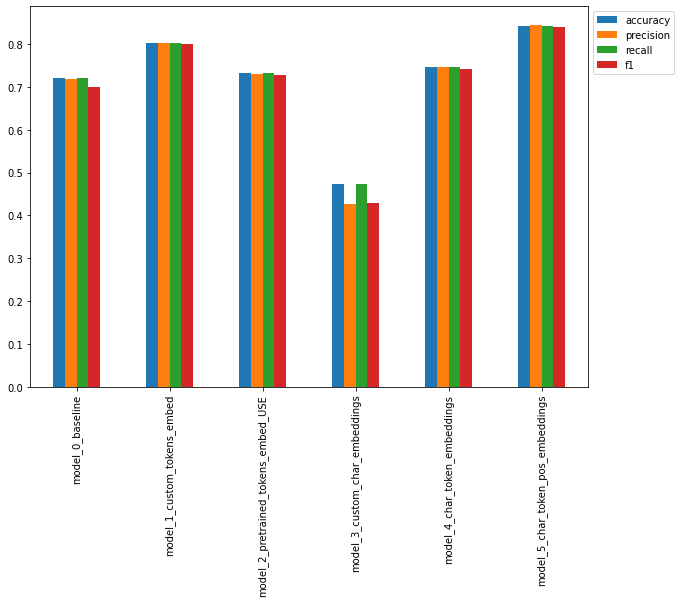

In [117]:
all_model_results.plot(kind = "bar", figsize = (10, 7)).legend(
    bbox_to_anchor = (1.0, 1.0)
);

## Save Model 5 to file

In [118]:
# Save model 5 in the save model format
model_5.save("models/skimlit_tribrit_model")

INFO:tensorflow:Assets written to: models/skimlit_tribrit_model/assets


INFO:tensorflow:Assets written to: models/skimlit_tribrit_model/assets


In [120]:
# Load the model
loaded_model_5 = tf.keras.models.load_model("models/skimlit_tribrit_model")


2022-06-08 00:30:41.759727: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-06-08 00:30:41.926419: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-06-08 00:30:41.955604: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-06-08 00:30:43.078855: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-06-08 00:30:43.126496: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_sh

In [122]:
# Evaluate the loaded model
loaded_model_5_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = tf.argmax(loaded_model_5.predict(val_char_token_pos_dataset), axis = 1)
)
loaded_model_5_results



945/945 [==============================] - 60s 63ms/step


{'accuracy': 84.27446047927975,
 'precision': 0.8455186635162628,
 'recall': 0.8427446047927976,
 'f1': 0.8387264740327381}

## Test Data

In [123]:
test_labels = tf.argmax(loaded_model_5.predict(test_char_token_pos_dataset), axis = 1)
test_labels

942/942 [==============================] - 65s 69ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [130]:
# Evaluate the models predictions
test_results = calculate_results(
    y_true = test_labels_encoded,
    y_pred = test_labels
)
test_results

{'accuracy': 83.79293180686909,
 'precision': 0.8397690859604977,
 'recall': 0.8379293180686909,
 'f1': 0.83403232153347}